In [4]:
# Data format preprocessed
'''
[ main array
    [ block of continuous frames ! not shuffled
        [ single frame
            [ 
                [
                    resized fullscreen
                ],
                [
                    minimap 
                ]
            ],
            [ 
                player's action        
            ]
        ],
        ...
    ],
    ...
 ]
'''
# Data format raw
'''
[ main array ! break when stop recording
    [ single frame
            [ 
                [
                    resized fullscreen
                ],
                [
                    minimap 
                ]
            ],
            [ 
                player's action        
            ]
        ],
        ...
    ],
    ...
 ]
'''
print()

In [ ]:
from screen_consts import WIDTH, HEIGHT, get_preproc_coordinates
from image_preproc import preproc_img
from getkeys import key_check
from image_preproc import get_preprocessed_and_map
import time
import numpy as np
from PIL import ImageGrab
from threading import Thread
from pynput.mouse import Listener
from functools import partial
import os
import win32api

isPressed = False
def on_click(x, y, button, pressed):
    global isPressed
    isPressed = pressed
    
def detect_clicks():
    with Listener(on_click=partial(on_click)) as listener:
        listener.join()

def get_frame_data():
    img = ImageGrab.grab()    
    prepocessed, minimap = get_preprocessed_and_map(np.array(img))
    return prepocessed, minimap


BATCH_SIZE = 10000
data = []
data_path = "data\\"
avg_framerate = []

# Count existing frames
frames = 0
for file_name in os.listdir(data_path):
    num = int(file_name.split(sep="-")[2][:-4])
    if frames < num:
        frames = num
print("Last save was", frames, "frames")

# New thread for click detecting
thread = Thread(target=detect_clicks)
thread.start()

def save_data():
    global data, frames, avg_framerate, last_save_frames
    frames_range = (frames, frames + len(data))
    frames += len(data)
    np.save(data_path + "frame-{}-{}.npy".format(*frames_range), data)
    data = []
    print("Saved {}-{} frames".format(*frames_range))
    print('Average framerate(period):', np.mean(avg_framerate))
    avg_framerate = []

print("Start/Pause action with Alt+T")
paused = True
timings = [0 for i in range(10)]
keys = key_check()
while True:    
    keys = key_check()
    if "ALT" in keys and "T" in keys:
        paused ^= 1
        if paused:
            print("Stop action, press Alt+T to continue")
            
            # Save on recording break
            save_data()
        else:
            print("Start action in 3 sec.")
            for i in list(range(3))[::-1]:
                time.sleep(1)
                print(i + 1)
            time.sleep(1)
            print("action!")
        time.sleep(0.5)   
        
    clock_prev = time.clock()
    prepocessed, minimap = get_frame_data()
    
    if not paused:
        x, y = get_preproc_coordinates(win32api.GetCursorPos(), 1680, 1050)
        data.append([[prepocessed, minimap], [x, y, isPressed, "Q" in keys, "W" in keys, "E" in keys]])

        if len(data) >= BATCH_SIZE:
            save_data()
        else:
            time_elapsed = round((time.clock() - clock_prev)*1000)
            avg_framerate.append(time_elapsed)
            timings.pop(0)
            timings.append(time_elapsed)
            if np.mean(timings) > 50:
                print('Corrupting data: low framerate. Log:', timings)
            #paused = True
        #print('Took {} ms'.format(time_elapsed))

Last save was 10000 frames
Start/Pause action with Alt+T
Start action in 3 sec.
3
2
1
action!
Stop action, press Alt+T to continue
Saved 10000-11033 frames
Average framerate(period): 33.77541142303969


<IPython.core.display.Javascript object>


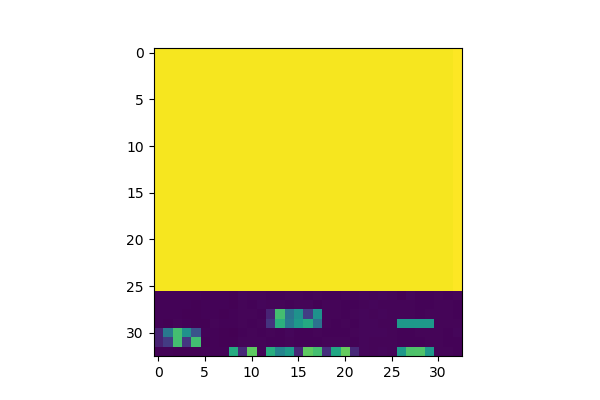

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from image_preproc import get_preprocessed_and_map
from getkeys import key_check

from PIL import ImageGrab
def get_image():
    img = ImageGrab.grab()    
    preprocessed, minimap = get_preprocessed_and_map(np.array(img))
    return minimap

gridsize = (1, 1)
fig = plt.figure(figsize=(6, 4))
ax1 = plt.subplot2grid(gridsize, (0, 0))

im1 = ax1.imshow(get_image())

def update(i):
    if 'T' in key_check():
        img = get_image()
        im1.set_data(img)
    #im1.set_data(preproc_img(grab_screen()))

ani = FuncAnimation(plt.gcf(), update, interval=1)
plt.show()

In [3]:
print(get_image().shape)

(33, 33)


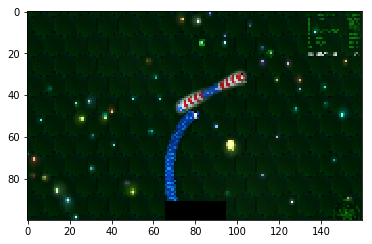

In [13]:
from PIL import Image
img = Image.open("D:\Windows\Desktop\image.png")
import matplotlib.pyplot as plt
import numpy as np
from image_preproc import preproc_img, prepare_image
plt.imshow(preproc_img(np.array(img)))